##Learning Objectives:

_____________
By the end of the lesson, learners are expected to achieve the following objectives:

- Understand the different methods of modeling with transformers, encoder-based, decoder-based and encoder-decoder models.
- Understand how encoder-based models are trained using Masked language modeling (MLM) objective.
- Understand how decoder-based models are trained using Causal language modeling (CLM) objective.
- Understand the architecture and implementation of popular transformers models such as BERT, GPT and T5.

##Prerequisites:
_____
- Familiarity with deep learning and natural language processing (NLP) concepts such as tokenization, word embeddings, and Language Modeling.
Familiarity with transformers architecture, including Multi-headed and self attention.
- Knowledge of Python programming and popular deep learning frameworks such as TensorFlow or PyTorch.


# 3. Modeling

Transformers have revolutionized natural language processing by providing state-of-the-art results on various tasks such as classification, question answering, text generation, etc. These models can be categorized into three different methods of modeling:

## 3.1 Encoder-based Models

These transformers are based on the encoder part of the original transformer model and perform auto-encoding or encoder-based tasks.

The model is trained on a large corpus of text data using a variant of the masked language modeling (MLM) objective, where the model is trained to predict masked words in the input text.

* **Input type** A sequence of tokens or words
* **Output type:** Embeddings for each token or the representation of the whole
input sequence
* **Use case:** Good for classification, extractive question answering
* **Examples:** BERT, ALBERT, DistilBERT, ELECTRA, RoBERTa, DeBERTa, etc

In this type of model, the representation computed for a particular token is dependent on both the left (before the token) and the right (after the token) contexts. It's common to refer to this as bidirectional attention.

For example,



### 3.1.1 BERT **[(Bidirectional Encoder Representations from Transformers)](https://aclanthology.org/N19-1423.pdf)**
 is an encoder-based model that is pre-trained on a large corpus of text and fine-tuned for specific downstream tasks such as sentiment analysis or named entity recognition. It uses a masked language modeling (MLM) objective during pre-training to learn context-aware token embeddings. BERT has achieved state-of-the-art results on a wide range of NLP tasks.

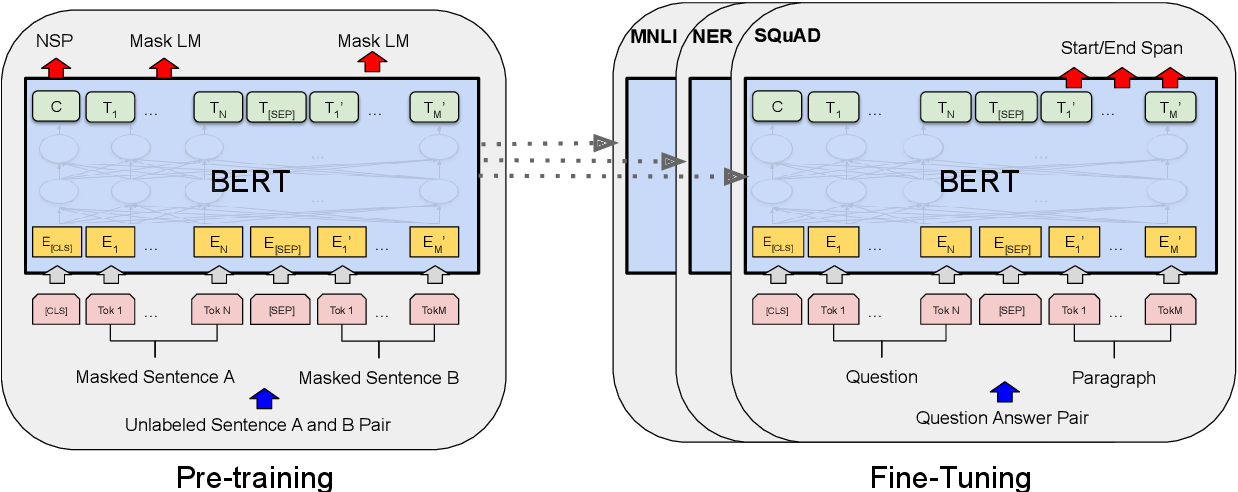

**Figure:** [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://aclanthology.org/N19-1423.pdf)

The figure of pre-training and fine-tuning in BERT represents the two main stages of the model's training process:

1. **Pre-training:**

  **Masked Language Modeling (MLM)**: It involves training the BERT model on a large corpus of text to learn general language representations. This is done by masking certain words in the input text and training the model to predict the masked words based on the context of the surrounding words. This is known as masked language modeling (MLM) and is represented in the figure by the "Pre-training with MLM" box.

  **Next sentence prediction (NSP)**: The model is trained to predict whether two sentences follow each other in the original text or not. This is represented in the figure by the "Pre-training with NSP" box.

2. **Fine-tuning:** Once the pre-training is complete, the model is fine-tuned on a downstream task specific to the application. This involves taking the pre-trained BERT model and training it further on a smaller labeled dataset for the specific task. The fine-tuning can be done with a variety of methods, such as adding a classification layer on top of the pre-trained model or fine-tuning the entire model with a smaller learning rate.


#### 3.1.1.1 The BERT Architecture
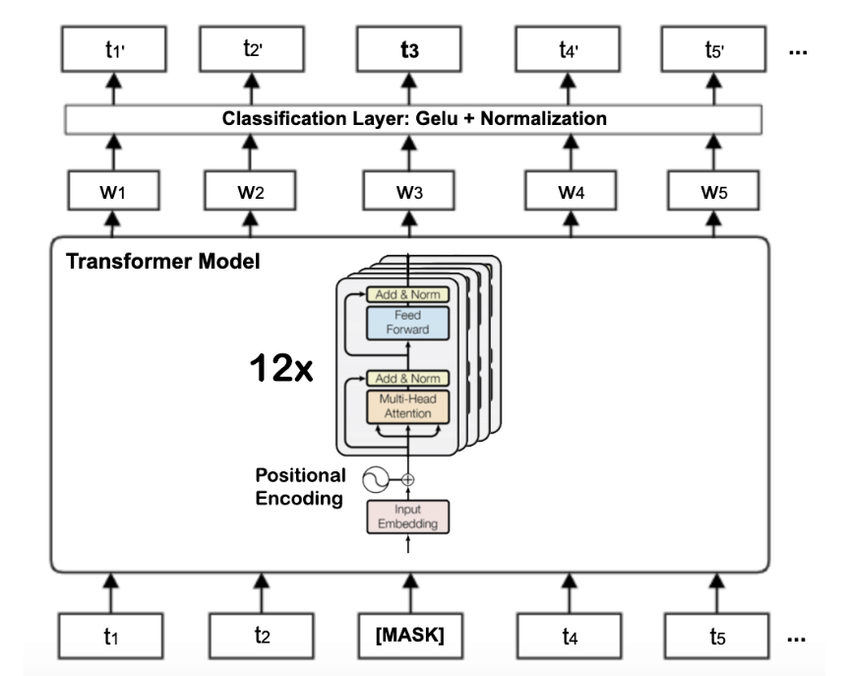

**Figure:**[RUBERT Paper](https://www.researchgate.net/publication/349546860_RUBERT_A_Bilingual_Roman_Urdu_BERT_Using_Cross_Lingual_Transfer_Learning)

The BERT architecture consists of multiple layers (12/24 for base/large) of bidirectional Encoder-based transformers. The input to the model is tokenized text, which is fed into the embedding layer. The embedding layer converts each token into a fixed-length vector. These vectors are then passed through multiple layers of transformer blocks, where each block consists of self-attention and feedforward layers. The final output of the model is a sequence of vectors that represent the input text.

##### **Implementation of BERT Multi-headed Attention:**

```
MLM Objective:
--------------
The animal didn't cross the street
The [MASK] didn't cross the [MASK]
```

In [ ]:
class BertMultiHeadedAttention(nn.Module):
    "BERT Encoder Multi-Head Attention with input_mask"

    def __init__(self, input_dim: int, num_heads: int, bias: bool = True,
                 attn_drop: float = 0.1, proj_drop: float = 0.1):
        super().__init__()
        assert input_dim % num_heads == 0  # input dimension must be divisible by num_heads
        self.nh = num_heads  # number of attention heads
        self.qkv = nn.Linear(input_dim, input_dim * 3, bias=bias)  # linear layer to project queries, keys, values
        self.proj = nn.Linear(input_dim, input_dim, bias=bias)  # linear layer to project final output
        self.attn_drop = nn.Dropout(attn_drop)  # attention dropout layer to prevent overfitting
        self.proj_drop = nn.Dropout(proj_drop)  # final output dropout layer to prevent overfitting

    def forward(self, x: torch.Tensor, input_mask: torch.Tensor):
        B, S, C = x.shape  # batch size, sequence length, input dimension

        # split into queries, keys, & values of shape (batch size, num heads, sequence length, head size)
        qkv = self.qkv(x).reshape(B, S, 3, self.nh, C // self.nh).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = q @ k.transpose(-2, -1)  # calculate dot product attention for each head
        attn = attn / math.sqrt(k.size(-1))  # scale by square root of output dimension

        # Assume input_mask is shape (batch_size, sequence_length) where 1 is masked and 0 is unmasked
        mask = input_mask.unsqueeze(1).unsqueeze(2)  # add two extra dimensions
        attn = attn + mask * float('-inf')  # add mask tensor to attention scores

        attn = attn.softmax(dim=-1)  # apply softmax to get attention weights
        attn = self.attn_drop(attn)  # apply dropout to attention weights
        # this removes whole tokens which seems odd, but is from the original Transformer paper

        x = (attn @ v).transpose(1, 2).reshape(B, S, C)  # apply attention weights to values and reshape back to (B, S, C)

        return self.proj_drop(self.proj(x))  # apply final linear layer to get output

## 3.2 Decoder-based Models
These transformers are based on the decoder part of the original transformer model. They are auto-regressive or decoder-based and are useful for generating texts.

Decoder-based models can be trained using Causal Language Modeling (CLM), where the model is trained to predict the next token given the previous tokens.

* **Input type:** A sequence of tokens or words
* **Output type:** A sequence of tokens or words
* **Use case:** Good for generating texts
* **Examples:** GPT, DistilGPT, ChatGPT etc

The representation computed for a given token in this
architecture depends only on the left context. This is often called
causal or autoregressive attention.

For example,



### 3.2.1 GPT-3  **[(Generative Pre-trained Transformer 3)](https://proceedings.neurips.cc/paper/2020/file/1457c0d6bfcb4967418bfb8ac142f64a-Paper.pdf)**
 is a decoder-based model that is pre-trained on a large corpus of text and fine-tuned for specific tasks such as language translation or text completion. It uses a language modeling objective during pre-training to learn to generate coherent and fluent text. GPT-3 has shown impressive results in generating human-like text and completing tasks.

 It uses a pre-trained transformer encoder to encode the input sequence and a transformer decoder to generate the output sequence. During inference, the model generates the output tokens one at a time, conditioned on the previous tokens.

#### 3.2.1.1 GPT Architecture and Task-Specific Input Transformations
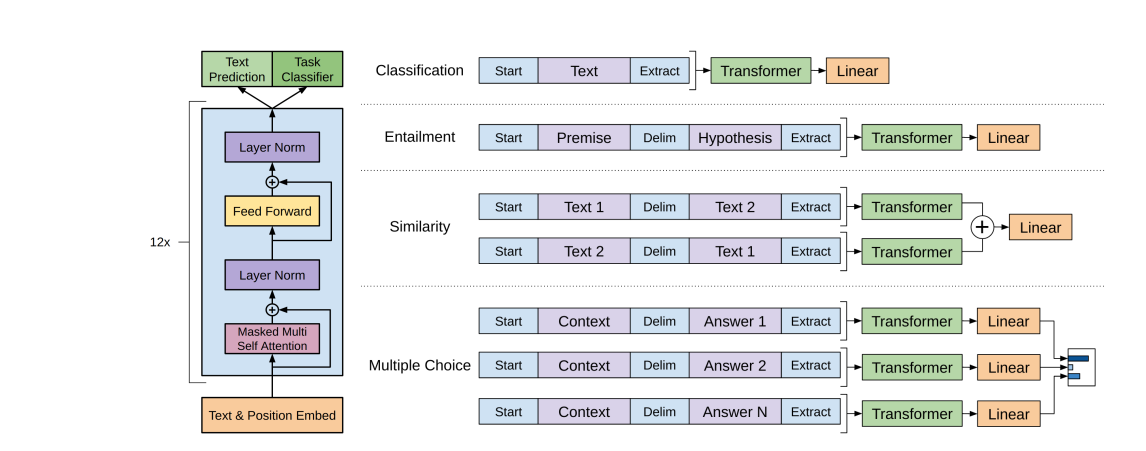

**Figure:** [Improving Language Understanding
by Generative Pre-Training](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

The original GPT paper proposes a 12-layer decoder-only transformer architecture (for training a language model) with each layer containing a multi-head self-attention mechanism and a feedforward neural network. The input to each layer is the output of the previous layer, and the output of the final layer is the predicted probability distribution over the next word in the sequence.

During training, the model is fed a sequence of tokens, where each token is a word or a special token indicating the start or end of a sentence. The model is trained using a masked self-attention mechanism, where each token in the input sequence is masked so that the model cannot use future tokens to predict the current token. This forces the model to learn to predict each token based only on the preceding tokens in the sequence.

In addition to the self-attention mechanism, the figure shows a number of task-specific transformations that can be added to the model to perform different language tasks. For example, a classification task may involve adding a single linear layer on top of the final transformer layer to predict a label for the input sequence. Similarly, an entailment task may involve adding a feedforward network to the final transformer layer to predict whether one sentence entails another.


##### **Implementation of GPT Multi-headed Attention:**

```
CLM Objective:
--------------
The animal didn't [MASK]
The animal didn't cross [MASK]
The animal didn't cross the [MASK]
The animal didn't cross the street [MASK]
```
Turned into:
```
The animal didn't [MASK] [MASK] [MASK]
The animal didn't cross [MASK] [MASK]
The animal didn't cross the [MASK]
The animal didn't cross the street [MASK]
```

In [ ]:
class GPTMultiHeadedAttention(nn.Module):
    "GPT Decoder Multi-Head Attention with causal mask"

    def __init__(self,
                 input_dim: int,
                 num_heads: int,
                 max_seq_len: int,
                 bias: bool = True,
                 attn_drop: float = 0.1,
                 proj_drop: float = 0.1
      ):
        super().__init__()
        assert input_dim % num_heads == 0 # input dimension must be divisible by num_heads
        self.nh = num_heads # number of attention heads
        self.qkv = nn.Linear(input_dim, input_dim * 3, bias=bias) # linear layer to project queries, keys, values
        self.proj = nn.Linear(input_dim, input_dim, bias=bias) # linear layer to project final output
        self.attn_drop = nn.Dropout(attn_drop) # attention dropout layer to prevent overfitting
        self.proj_drop = nn.Dropout(proj_drop) # final output dropout layer to prevent overfitting
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(max_seq_len, max_seq_len))
                                .view(1, 1, max_seq_len, max_seq_len))

    def forward(self, x: torch.Tensor):
        B, S, C = x.shape # batch size, sequence length, input dimension

        # split into queries, keys, & values of shape (batch size, num_heads, sequence length, head size)
        qkv = self.qkv(x).reshape(B, S, 3, self.nh, C // self.nh).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = q @ k.transpose(-2, -1) # calculate dot product attention for each head
        attn = attn / math.sqrt(k.size(-1)) # scale by square root of output dimension

        # Apply causal mask to attention
        attn = attn.masked_fill(self.mask[:, :, :S, :S] == 0, float('-inf'))

        attn = attn.softmax(dim=-1) # apply softmax to get attention weights
        attn = self.attn_drop(attn) # apply dropout to attention weights

        x = (attn @ v).transpose(1, 2).reshape(B, S, C) # apply attention weights to values and reshape back to (B, S, C)

        return self.proj_drop(self.proj(x)) # apply final linear layer to get output

**Note:**
In practice, it might be difficult to distinguish between applications for encoder-only and decoder-only architectures. For tasks like translation that are typically thought of as sequence-to-sequence tasks, decoder-only models, such as those in the GPT family, can be used. Similarly, summarization activities that are often related to encoder-decoder or decoder-only models can be applied using encoder-only models like BERT.

## 3.3 Encoder-Decoder Models
 These transformers consist of both encoder and decoder components and are used for sequence-to-sequence (Seq2seq) modeling.

 Encoder-decoder models are typically trained using a teacher-forcing approach, where the decoder is trained to generate the correct output given the correct input.

* **Input type:** A sequence of tokens or words
* **Output type:** A sequence of tokens or words
* **Use case:** Good for summarization, language translation, generative question answering
* **Examples:** BART and T5

For example,



### 3.3.1  T5 **[(Text-to-Text Transfer Transformer)](https://arxiv.org/abs/1910.10683)**
is an encoder-decoder model that is pre-trained on a diverse set of text-to-text tasks such as machine translation, summarization, and generative question answering. It uses a pre-defined set of operations to map the input to the output format, making it highly flexible and adaptable to a wide range of tasks. T5 has shown impressive results on various NLP tasks and is currently one of the most widely used transformer models.



#### **3.3.1.1 T5 Landscape and Capabilities**

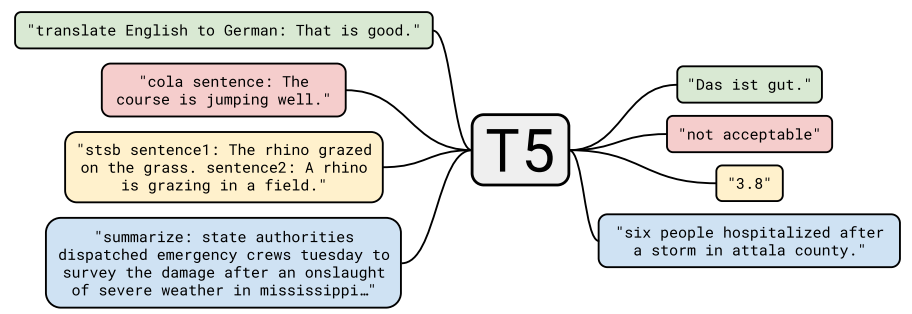

**Figure:** [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf)

#### **3.3.1.2 Unsupervised Language Modeling Objective:**

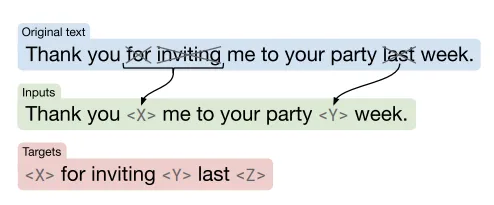

**Figure:** [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf)

In the T5 paper, the language modeling objective used for pre-training is called "denoising" or "masked language modeling". The model is trained to predict missing or corrupted tokens in the input sequence, with 15% of tokens randomly dropped out and replaced by a special sentinel token. The target corresponds to all the dropped-out spans of tokens, delimited by the same sentinel tokens used in the input sequence, with an additional sentinel token marking the end of the target sequence. This objective is inspired by BERT's **masked language modeling** and **word dropout regularization** technique, and is designed to teach the model generalizable knowledge that will be useful in downstream tasks without requiring labeled data.

#### 3.3.1.3 T5 Architecture

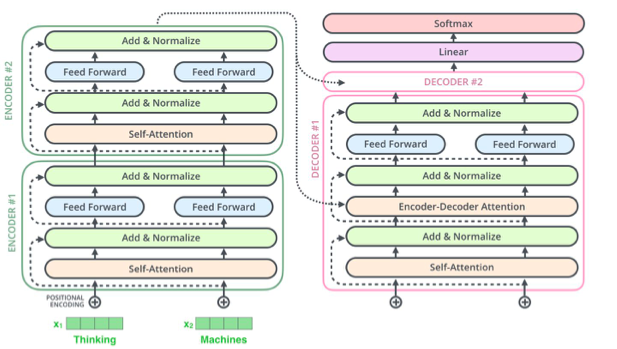

**Figure:** [T5 and large language models: The good, the bad, and the ugly](https://colinraffel.com/talks/stanford2021t5.pdf)
We observe that T5 model structure is just a standard sort of vanilla encoder-decoder transformer.